# DS2500 Group 34 Final Project
Catarina Bettencourt and Erin O'Neill
12/04/2023
***

## General code
***

### Imports

In [1]:
%matplotlib inline
import csv
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

### Constants

In [2]:
FILE_DIR = "Final Proj Files"

### Functions

#### Data Reading and Cleaning

In [3]:
def clean_and_combine(typ, lst1, lst1_col_loc, lst2, lst2_col_loc, reverse1_truefalse, reverse2_truefalse):
    '''
    Given two lists, will turn both lists into desired type, orient lists in desired direction, and combine lists into singular list
    (Requires pull_col and convert_totype functions)
    ---------------
    Parameters
    typ : Type
        can be str, int, float
    lst1 : lst of lst
        first 2d list
    lst1_col_loc : int
        desired column number of first 2d list to be combined
    lst2 : lst
        second 2d list
    lst2_col_loc : int
        desired column number of second 2d list to be added to the end of lst1 column
    reverse1_truefalse : bool
        for lst1: if True, does not reverse order of pulled column, if False, reverses order of pulled column
    reverse2_truefalse : 
        for lst1: if True, does not reverse order of pulled column, if False, reverses order of pulled column
        
    Returns
    clean_lst1: lst
        list with values in desired type containing first and second list's desired columns
    '''
    pull_lst1 = pull_col(lst1, lst1_col_loc)
    pull_lst2 = pull_col(lst2, lst2_col_loc)
    if reverse1_truefalse == True:
        pull_lst1.reverse()
    if reverse2_truefalse == True:
        pull_lst2.reverse()
    clean_lst1 = convert_totype(typ, pull_lst1)
    clean_lst2 = convert_totype(typ, pull_lst2)
    
    clean_lst1.extend(clean_lst2)
    
    return(clean_lst1)

In [4]:
def clean_data(fileloc, headerloc, col_num):
    '''
    given a file location, returns a cleaned column in list form
    (Requires csv import and read_csv_nonpd function)
    ---------------
    Parameters
    fileloc : int
        specific file location from files_lst
    headerloc : int
        used to remove header columns, number should be equal to location 
        of 1st desired row.
    col_num : int
        the location of the desired column to isolate
    Returns
    lst: lst
        cleaned column that is turned into a list.
    '''
    data = read_csv_nonpd(FILE_DIR + "/" + files_lst[fileloc])
    noheader_data = data[headerloc:]
    lst = pull_col(noheader_data, col_num)
    
    return lst

In [5]:
def convert_totype(typ, lst):
    '''
    Converts all entries within a given list into desired type
    (No imports needed)
    ---------------
    Parameters
    typ : int, str, or float phrase
        desired data type to be converted to
    lst : lst
        list of values
    Returns
    typlst : lst
        lst with all values as desired type
    ''' 
    typlst = []
    for item in lst:
        typ_item = typ(item)
        typlst.append(typ_item)
    return(typlst)

In [6]:
def merged_df(shp, csv, col1, col2, col3, strike):
    '''
    Given a shape file, combines shape data with csv in dataframe
    (Requires geopandas and pandas import)
    ------------------
    Parameters
    shp : str
        file location of shape file
    csv : str
        file location of csv
    col1 : str
        column name to use for left_on
    col2 : str
        column name to strip and for right_on
    col3 : str
        column name for left and right_on
    strike : lst
        list of row names to strike
    Returns
    merged_df : dataframe
        dataframe containing csv and shape file data
    '''
    file = gpd.read_file(shp)
    file = file.drop_duplicates(col1)
    df = pd.read_csv(csv)
    df[col2] = df[col2].str.strip()
    df = df[~df[col2].isin(strike)]
    merged_df = file.merge(df, left_on = [col1, col3], right_on = [col2, col3])
    
    return merged_df


In [7]:
def multifile_to_df(fileloc_lst, headerloc, col_num, typ, startval, header1, header2):
    '''
    Given a list of file locations and specific column to pull from, will create two-
    column dataframe with pulled column as first column and startval (adding +1 to startval each time a new file is being appended)

    (Requires pandas and numpy imports, requires clean_data and convert_totype functions)
    ---------------
    Parameters
    fileloc_lst : lst of ints
        list that corresponds to locations of desired files to read in
    headerloc : int
        number of header rows to skip before reading in data
    col_num : int
        desired column to pull from original data file
    typ : Type
        int, str, or float, will convert first column values to this type
    startval : int or float
        desired first value to append to second column
    header1 : str
        desired name of first column header
    header2 : 
        desired name of second column header
        
    Returns
    df : dataframe
        two column dataframe containing above-mentioned values
    '''
    col1 = []
    col2 = []
    combined_data = []
    for location in fileloc_lst:
        data = clean_data(location, headerloc, col_num)
    
        cleandata = convert_totype(typ, data)
        col1.extend(cleandata)
        for item in data:
            col2.append(startval)
        startval += 1
    i = 0
    for value in col1:
        minicombine = []
        minicombine.append(col2[i])
        minicombine.append(col1[i])
        combined_data.append(minicombine)
        i += 1
    
    df = pd.DataFrame(np.array(combined_data), columns=[header1, header2])

    return df

In [8]:
def multifile_to_fulldf(fileloc_lst, files_lst, col_key, row_key):
    '''
    Given list of files and list, returns dataframe containing all desired files' data
    (Requires pandas import)
    
    # https://pandas.pydata.org/docs/user_guide/merging.html
    ---------------
    Parameters
    fileloc_lst : lst of ints
        list that corresponds to locations of desired files to read in
    files_lst : lst of strings
        list of file names to call in
    col_key : str
        Desired column to remove specific value from
    row_key : str
        Desired value in column to remove from dataframe
        ex: 'United States' or 'Hawaii', 'Alaska', 'United States'
    
    Returns
    df_multifile : dataframe
        dataframe containing values from all desired files in the order in which they are listed in fileloc_lst
    '''
    df_multifile = pd.read_csv(FILE_DIR + '/' + files_lst[fileloc_lst[0]])
    df_multifile = df_multifile[~df_multifile[col_key].isin([row_key])]

    fileloc_slice = fileloc[1:]
    i = 0
    for loc in fileloc_slice:
        newloc = fileloc_slice[i]
        df_next = pd.read_csv(FILE_DIR + '/' + files_lst[newloc])
        df_next = df_next[~df_next[col_key].isin([row_key])]
        
        df_multifile = pd.concat([df_multifile, df_next])
        i += 1
    return (df_multifile)

In [9]:
def multifile_to_lst(file_loclst, headerloc, col_num):
    '''
    Given a list of file locations, will return an uncleaned list of values from specified column from all desired data files
    ---------------
    Parameters
    fileloc_lst : lst of ints
        list that corresponds to locations of desired files to read in
    headerloc : int
        number of header rows to skip before reading in data
    col_num : int
        desired column to pull from original data file
        
    Returns
    multi_lst : lst
        list of values from specified column
    '''
    multi_lst = []
    for location in file_loclst:
        data = clean_data(location, headerloc, col_num)
        multi_lst.extend(data)
    return(multi_lst)

In [10]:
def preprocess_csv(csv, col, strike):
    '''
    Given a csv, converts csv into dataframe removing specified list of values from desired column
    (Requires pandas import)
    ---------------
    Parameters
    csv : str
        location of csv file
    col : str
        name of csv column to strike specific values from
    strike : lst
        list of row names to strike specific column
        
    Returns
    df : dataframe
        read in csv and convert to df, removing rows representing Hawaii, Alaska, and United States
    '''
    df = pd.read_csv(csv)
    df[col] = df[col].str.strip()
    df = df[~df[col].isin(strike)]
    
    return df

In [11]:
def pull_col(data, col_num):
    '''
    Pulls a column from a given list of lists 
    (No imports needed)
    ---------------
    Parameters
    data : lst of lsts
        uncleaned 2d list
    col_num : int
        The number corresponding to the location of a specific column 
        in the data
    Returns
    fin_lst : lst
        a column from the 2d array data
    ''' 
    fin_lst = []

    for lst in data:
        item = lst[col_num]
        fin_lst.append(item)
    return fin_lst

In [12]:
def read_csv_nonpd(filename):
    '''
    (Obtained from class)
    given the name of a csv file, return its contents as a 2d list,
    including the header.
    (Requires csv import, does not require Pandas or Numpy)
    ---------------
    Parameters:
        filename: str
            name of file
    Returns:
        data : lst of lsts
            uncleaned 2d list
        '''
    data = []
    with open(filename, "r") as infile:
        csvfile = csv.reader(infile)
        for row in csvfile:
            data.append(row)
    return data

#### Analysis Functions

In [13]:
def cluster(df, col):
    '''
    Use KNN to create a pipeline with standarization and clustering, 
    add cluster labels to the dataframe and sort by clusters
    (Requires sklearn.cluster import KMeans, sklearn.preprocessing import StandardScaler, 
    sklearn.pipeline import make_pipeline and pandas import)
    ---------------
    Parameters
    df : dataframe
        dataframe to analyze
    col : str
        column name for algorithm
    Returns
    df : dataframe
        cluster analyzed dataframe
    '''
    cluster_data = df

    scaler = StandardScaler()
    kmeans = KMeans(n_clusters = 4, random_state = 0)

    pipeline = make_pipeline(scaler, kmeans)
    pipeline.fit(cluster_data[[col]])  

    df['cluster'] = pipeline.predict(cluster_data[[col]])
    df = df.sort_values(by = 'cluster')

    return df

In [14]:
def diagonal_correlation_analysis(df, corr_method, cmap_color, title):
    '''
    Given a dataframe, creates diagonal correlation analysis graph and returns raw correlation analysis results
    (Requires numpy and pandas import)
    
    # https://levelup.gitconnected.com/pearson-coefficient-of-correlation-using-pandas-ca68ce678c04
    # https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    ---------------
    Parameters
    df : dataframe
        dataframe to be analyzed
    corr_method : str
        desired correlation analysis method
        ex: 'pearson', 'kendall', 'spearman'
    cmap_color : str
        desired color for cmap variable
    title : str
        title of graph
    
    Returns
    rdf : df
        correlation analysis results
    '''
    rdf = df.corr(method=corr_method, numeric_only=True)
    mask = np.triu(np.ones_like(rdf, dtype=bool))
    sns.heatmap(rdf, 
                mask=mask,
                xticklabels=rdf.columns,
                yticklabels=rdf.columns,
                cmap=cmap_color,
                annot=True,
                linewidth=0.5).set(title=title)
    return rdf

In [15]:
def find_minmax(min_or_max, testlst, pull_lst1, pull_lst2, topnum):
    '''
    given a test list, finds the top (topnum value) that have the 
    highest value returns a 2d array containing max value and corresponding 
    second list value
    (Requires convert_totype function)
    
    .copy()
    https://www.programiz.com/python-programming/methods/list/copy
    ---------------
    Parameters
    min_or_max: str
        "min" or "max": determines if minimum or maxiumum is found
    testlst : lst
        list to test, will be converted to integers.
    pull_lst1 : lst
        corresponding info to be reported
    pull_lst2 : lst
        corresponding info to be reported
    topnum : int
        how many extremes to find (ex: topnum = 5 means the top 5 values 
        will be reported).

    Returns
    max_lst: list of lists
        2d array with two columns, max value and corresponding value 
        from pull_lst

    '''
    val_lst = []
    i = 0    
    iterate = []
    while i < topnum:
        iterate.append(1)
        i += 1
    copyintlst = convert_totype(int, testlst)
    intlst = copyintlst.copy()
    newpull_lst1 = pull_lst1.copy()
    newpull_lst2 = pull_lst2.copy()
    if min_or_max == 'max':
        for j in iterate:
            val = max(intlst)
            loc = intlst.index(val)
            info1 = newpull_lst1[loc]
            info2 = newpull_lst2[loc]
            vals = [info1, info2, val]
            val_lst.append(vals)
            intlst.pop(loc)
            newpull_lst1.pop(loc)
            newpull_lst2.pop(loc)
    if min_or_max == "min":
        for i in iterate:
            val = min(intlst)
            loc = intlst.index(val)
            info1 = newpull_lst1[loc]
            info2 = newpull_lst2[loc]
            vals = [info1, info2, val]
            val_lst.append(vals)
            intlst.pop(loc)
            newpull_lst1.pop(loc)
            newpull_lst2.pop(loc)

    return(val_lst)

#### Visualization Functions

In [16]:
def corr_analysis_scatter(xvals, yvals, colors, df, column, row, xlabel, ylabel, titles):
    '''
    Given list of x and y values, creates scatterplot with linear line of bestfit and r val shown
    (Requires matplotlib, numpy and pandas imports)
    ---------------
    Parameters
    xvals : lst of ints
        list of x values to plot
    yvals : lst of ints
        list of y values to plot
    colors : str
        matplotlib color to use for graph
    df : dataframe
        dataframe for r value analysis
    column : str
        name of datafram column to pull from
    row : int
        index of value from column to pull
    xlabel : str
        x axis label
    ylabel : str
        y axis label
    title : string
        title of graph
    Returns:
    None
    '''     
    plt.scatter(xvals, yvals, color=colors)
    z = np.polyfit(xvals, yvals, 1)
    p = np.poly1d(z)
    equation = 'Line of Best Fit: y = ' + str(p)
    rdf = df.corr(method='pearson', numeric_only=True)
    rcol = list(rdf[column])
    rval = round(rcol[row], 2)
    rvaltxt = 'Coefficient of Correlation, r = ' + str(rval)
    plt.text(45, 1270, equation)
    plt.text(45, 1250, rvaltxt)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(titles)
    plt.plot(xvals, p(xvals), color='black', linewidth=1, linestyle='--')

In [17]:
def horizontal_bar_graph(title, xdata, xlabel, xlim, ylabels, colors):
    '''
    Given list of values and corresponding labels, creates a horizontal bar graph
    (Requires matplotlib and numpy import)
    https://realpython.com/how-to-use-numpy-arange/
    ---------------
    Parameters
    title : str
        title of graph
    xdata : lst of ints or floats
        list of values to be plotted
    xlabel : str
        label for x-axis
    xlim : int
        limit for max value on x-axis
    lst2_col_loc : 
        1
    ylabels : lst
        labels for y-axis that corresponds to xdata values
    colors : lst of strs
        list of strings that correspond to desired matplotlib colors
    Returns
    None
    '''
    y_pos = np.arange(len(ylabels))
    fig, ax = plt.subplots()

    hbars = ax.barh(y_pos, xdata, align='center', color=colors)
    ax.set_yticks(y_pos, labels=ylabels)
    ax.invert_yaxis() 
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.bar_label(hbars)
    ax.set_xlim(right=xlim)
    plt.show()

In [18]:
def plot_choropleth(merged_df, col, label, title):
    '''
    Given merged dataframe, plots choropleth graph
    ------------
    Parameters
    merged_df : dataframe
        dataframe containing shape data and relevant csv data
    col : str
        column to pull for analysis
    label : str
        label for above column
    title : str
        title of plot

    Returns
    None
    '''
    merged_df.plot(column = col, 
                   cmap = 'OrRd', 
                   legend = True, 
                   legend_kwds = {'label': label})
    plt.ylabel('Lattitude')
    plt.xlabel('Longitude')
    plt.title(title)
    plt.show()

In [19]:
def plot_cluster(df, x, y, title, y_label, x_label):
    ''' 
    Given cluster analysis dataframe, plots a graph of clusters with classification
    (Requires seaborn, matplotlib, and pandas imports)
    ---------------
    Parameters
    df : dataframe
        dataframe containing cluster analysis
    x : str
        name of column for x values
    y : str
        name of column for y values
    title : str
        title of plot
    y_label : str
        y axis labels
    x_label : str
        x axis labels
    Returns
    None 
    '''
    plt.figure(figsize = (10, 6))
    scatter = sns.scatterplot(data = df, x = x, y = y, hue = 'cluster', style = 'region', palette ='bright', markers = ["o", "s", "D", "^", "v"])
    plt.xticks([])
    sns.set(style = 'whitegrid')
    
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
    
    plt.show()

__Commonly Used Variables__

In [20]:
# global: https://www.programiz.com/python-programming/global-keyword    
global files_lst
files_lst = os.listdir(FILE_DIR) 
fileloc = [2, 3, 4, 5, 6, 7]

In [21]:
shp = 'Final Proj Files/usa-states-census-2014.shp'
csv_2017 = 'Final Proj Files/sat_2017.csv'
csv_2022 = 'Final Proj Files/sat_2022.csv'
clean_2017 = preprocess_csv(csv_2017, 'state', ['Hawaii', 'Alaska', 'United States'])
clean_2022 = preprocess_csv(csv_2022, 'state', ['Hawaii', 'Alaska', 'United States'])
merged_2017 = merged_df(shp, csv_2017, 'NAME', 'state', 'region', ['Hawaii', 'Alaska', 'United States'])
merged_2022 = merged_df(shp, csv_2022, 'NAME', 'state', 'region', ['Hawaii', 'Alaska', 'United States'])

## Geographic Overview of SAT Data by State, Comparison of 2017 and 2022
***

In [22]:
merged_2017.explore()

In [23]:
merged_2022.explore()

## Question 1: How Do SAT Scores Vary by State and Segion? Comparison of 2017 and 2022
***

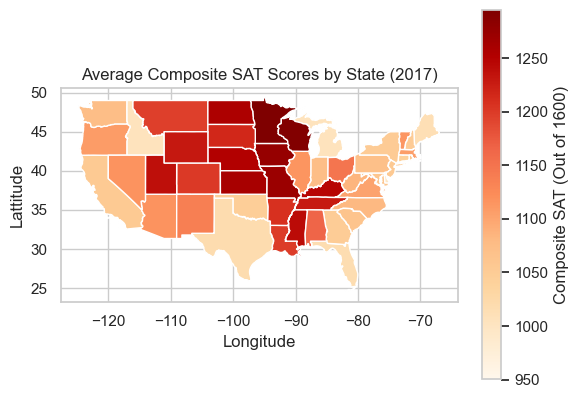

In [39]:
plot_avg_2017 = plot_choropleth(merged_2017, 
                                'total_sat', 
                                'Composite SAT (Out of 1600)', 
                                'Average Composite SAT Scores by State (2017)')

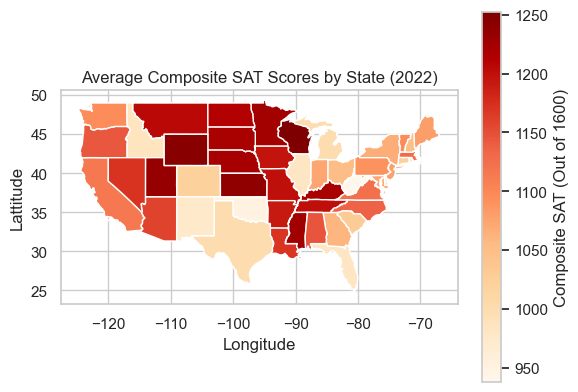

In [41]:
plot_avg_2022 = plot_choropleth(merged_2022, 
                                'total_sat', 
                                'Composite SAT (Out of 1600)', 
                                'Average Composite SAT Scores by State (2022)')

## Question 2: How Does Percent Taking Vary by State and Region? Comparison of 2017 and 2022
***

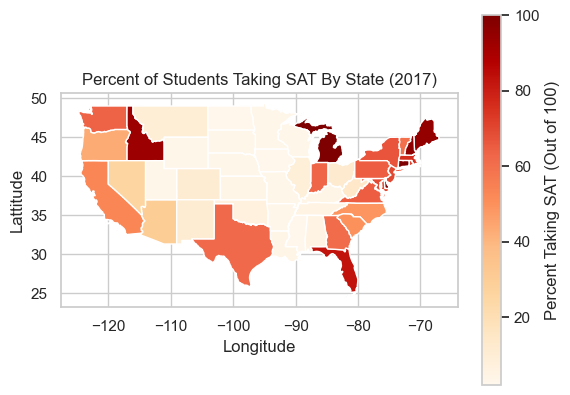

In [42]:
plot_percent_2017 = plot_choropleth(merged_2017, 
                                    'percent_taking', 
                                    'Percent Taking SAT (Out of 100)', 
                                    'Percent of Students Taking SAT By State (2017)')

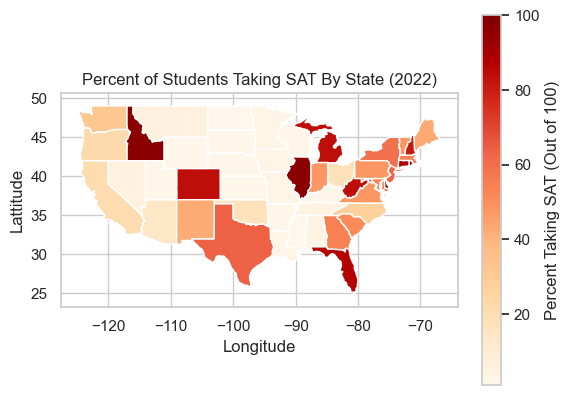

In [43]:
plot_percent_2022 = plot_choropleth(merged_2022, 
                                    'percent_taking', 
                                    'Percent Taking SAT (Out of 100)', 
                                    'Percent of Students Taking SAT By State (2022)')

## Question 3: Is The Average Total SAT Score of a State Impacted by the Percent of Students Taking the SAT? (All years)
***

,total_sat,reading_writing,math,percent_taking
total_sat,1.000000,0.995573,0.996169,-0.844187
reading_writing,0.995573,1.000000,0.983598,-0.853884
math,0.996169,0.983598,1.000000,-0.828586
percent_taking,-0.844187,-0.853884,-0.828586,1.000000


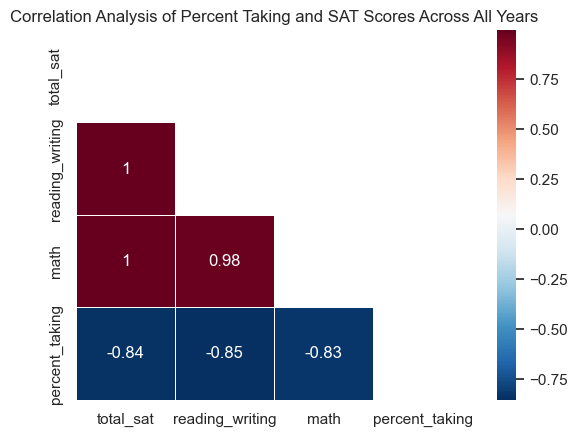

In [45]:
allyears_df = multifile_to_fulldf(fileloc, files_lst, 'state', 'United States')
diagonal_correlation_analysis(allyears_df, 
                              'pearson', 
                              'RdBu_r', 
                              'Correlation Analysis of Percent Taking and SAT Scores Across All Years')

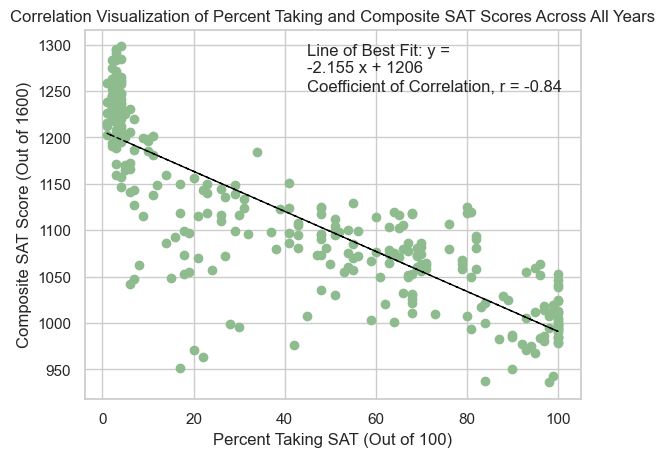

In [44]:
alltotal_satscores = list(allyears_df['total_sat'])
allpercents = list(allyears_df['percent_taking'])

corr_analysis_scatter(allpercents, 
                      alltotal_satscores, 
                      'darkseagreen', 
                      allyears_df, 
                      'total_sat', 
                      3, 
                      'Percent Taking SAT (Out of 100)', 
                      'Composite SAT Score (Out of 1600)', 
                      'Correlation Visualization of Percent Taking and Composite SAT Scores Across All Years')


## Question 4: Visualizing the Top and Bottom 5 States in Each Category, Comparison of 2017 and 2022
***

In [30]:
barcolors = ['darkgreen', 'green', 'seagreen', 'mediumseagreen', 'darkseagreen', 'salmon', 'tomato', 'indianred', 'firebrick', 'darkred']

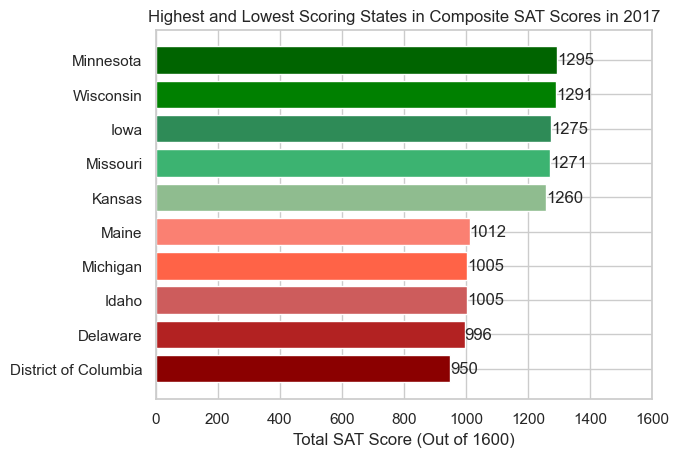

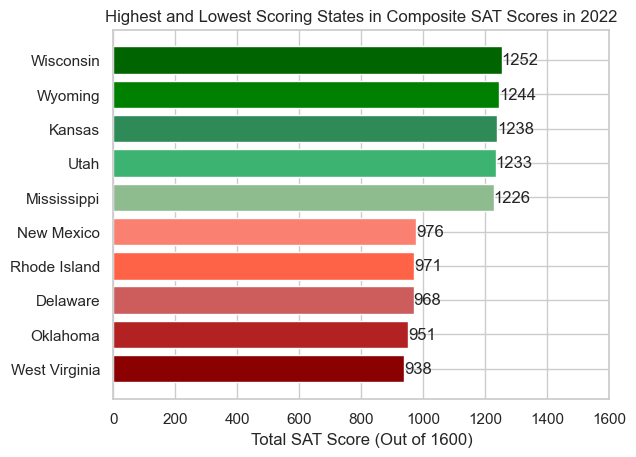

In [46]:
horizontal_bar_graph('Highest and Lowest Scoring States in Composite SAT Scores in 2017',
                     clean_and_combine(int, 
                                       find_minmax('max', clean_data(2, 2, 1), clean_data(2, 2, 0), clean_data(2, 2, 4), 5), 
                                       2, 
                                       find_minmax('min', clean_data(2, 2, 1), clean_data(2, 2, 0), clean_data(2, 2, 4), 5), 
                                       2, 
                                       False, 
                                       True), 
                     'Total SAT Score (Out of 1600)', 
                     1600, 
                     clean_and_combine(str, 
                                       find_minmax('max', clean_data(2, 2, 1), clean_data(2, 2, 0), clean_data(2, 2, 4), 5), 
                                       0, 
                                       find_minmax('min', clean_data(2, 2, 1), clean_data(2, 2, 0), clean_data(2, 2, 4), 5), 
                                       0, 
                                       False, 
                                       True), 
                     barcolors)

horizontal_bar_graph('Highest and Lowest Scoring States in Composite SAT Scores in 2022',
                     clean_and_combine(int, 
                                       find_minmax('max', clean_data(7, 2, 1), clean_data(7, 2, 0), clean_data(7, 2, 4), 5), 
                                       2, 
                                       find_minmax('min', clean_data(7, 2, 1), clean_data(7, 2, 0), clean_data(7, 2, 4), 5), 
                                       2, 
                                       False, 
                                       True), 
                     'Total SAT Score (Out of 1600)', 
                     1600, 
                     clean_and_combine(str, 
                                       find_minmax('max', clean_data(7, 2, 1), clean_data(7, 2, 0), clean_data(7, 2, 4), 5), 
                                       0, 
                                       find_minmax('min', clean_data(7, 2, 1), clean_data(7, 2, 0), clean_data(7, 2, 4), 5), 
                                       0, 
                                       False, 
                                       True), 
                     barcolors)

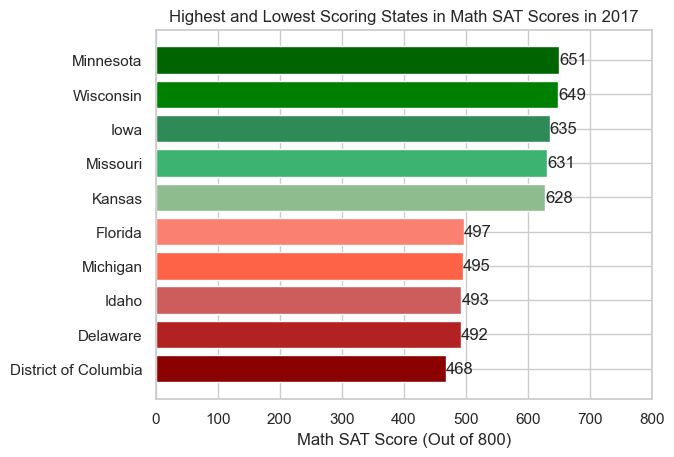

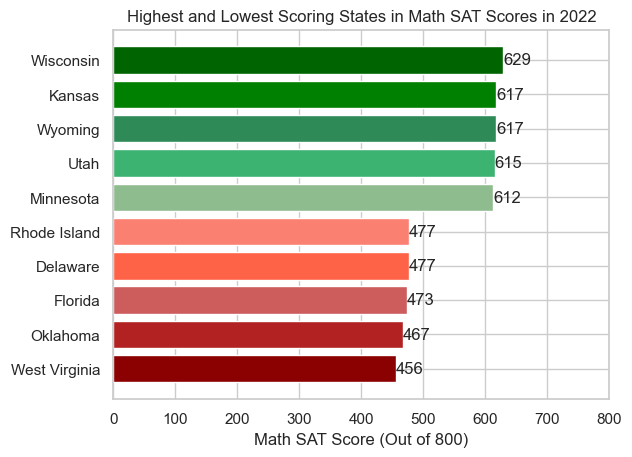

In [47]:
horizontal_bar_graph('Highest and Lowest Scoring States in Math SAT Scores in 2017', 
                     clean_and_combine(int, 
                                       find_minmax('max', clean_data(2, 2, 3), clean_data(2, 2, 0), clean_data(2, 2, 4), 5), 
                                       2, 
                                       find_minmax('min', clean_data(2, 2, 3), clean_data(2, 2, 0), clean_data(2, 2, 4), 5), 
                                       2, 
                                       False, 
                                       True), 
                     'Math SAT Score (Out of 800)', 
                     800, 
                     clean_and_combine(str, 
                                       find_minmax('max', clean_data(2, 2, 3), clean_data(2, 2, 0), clean_data(2, 2, 4), 5), 
                                       0, 
                                       find_minmax('min', clean_data(2, 2, 3), clean_data(2, 2, 0), clean_data(2, 2, 4), 5), 
                                       0, 
                                       False, 
                                       True), 
                     barcolors)
horizontal_bar_graph('Highest and Lowest Scoring States in Math SAT Scores in 2022', 
                     clean_and_combine(int, 
                                       find_minmax('max', clean_data(7, 2, 3), clean_data(7, 2, 0), clean_data(7, 2, 4), 5), 
                                       2, 
                                       find_minmax('min', clean_data(7, 2, 3), clean_data(7, 2, 0), clean_data(7, 2, 4), 5), 
                                       2, 
                                       False, 
                                       True), 
                     'Math SAT Score (Out of 800)', 
                     800, 
                     clean_and_combine(str, 
                                       find_minmax('max', clean_data(7, 2, 3), clean_data(7, 2, 0), clean_data(7, 2, 4), 5), 
                                       0, 
                                       find_minmax('min', clean_data(7, 2, 3), clean_data(7, 2, 0), clean_data(7, 2, 4), 5), 
                                       0, 
                                       False, 
                                       True), 
                     barcolors)

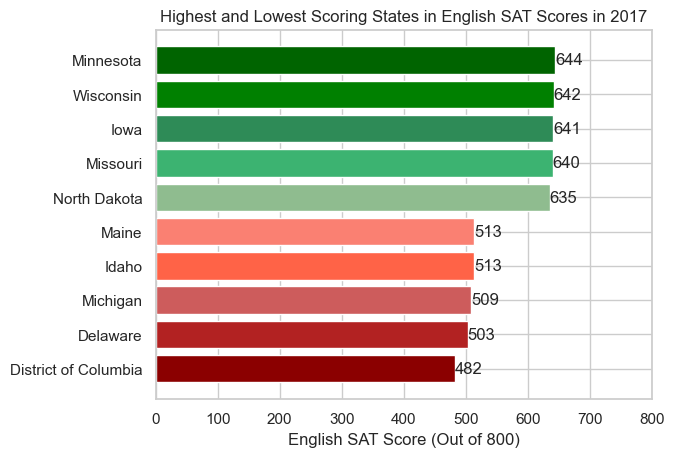

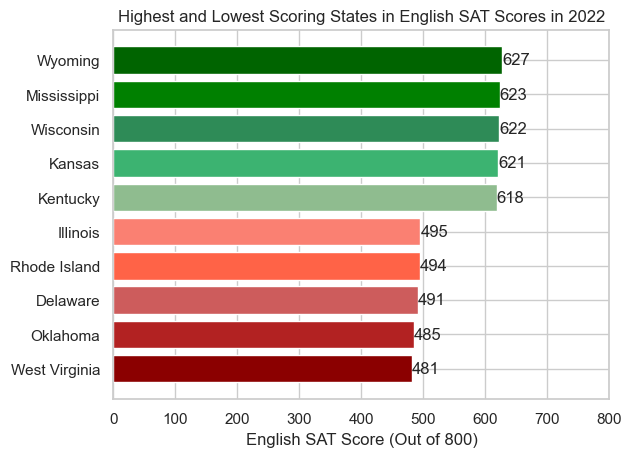

In [48]:
horizontal_bar_graph('Highest and Lowest Scoring States in English SAT Scores in 2017', 
                     clean_and_combine(int, 
                                       find_minmax('max', clean_data(2, 2, 2), clean_data(2, 2, 0), clean_data(2, 2, 4), 5), 
                                       2, 
                                       find_minmax('min', clean_data(2, 2, 2), clean_data(2, 2, 0), clean_data(2, 2, 4), 5), 
                                       2, 
                                       False, 
                                       True), 
                     'English SAT Score (Out of 800)', 
                     800, 
                     clean_and_combine(str, 
                                       find_minmax('max', clean_data(2, 2, 2), clean_data(2, 2, 0), clean_data(2, 2, 4), 5), 
                                       0, 
                                       find_minmax('min', clean_data(2, 2, 2), clean_data(2, 2, 0), clean_data(2, 2, 4), 5), 
                                       0, 
                                       False, 
                                       True), 
                     barcolors)
horizontal_bar_graph('Highest and Lowest Scoring States in English SAT Scores in 2022', 
                     clean_and_combine(int, 
                                       find_minmax('max', clean_data(7, 2, 2), clean_data(7, 2, 0), clean_data(7, 2, 4), 5), 
                                       2, 
                                       find_minmax('min', clean_data(7, 2, 2), clean_data(7, 2, 0), clean_data(7, 2, 4), 5), 
                                       2, 
                                       False, 
                                       True), 
                     'English SAT Score (Out of 800)', 
                     800, 
                     clean_and_combine(str, 
                                       find_minmax('max', clean_data(7, 2, 2), clean_data(7, 2, 0), clean_data(7, 2, 4), 5), 
                                       0, 
                                       find_minmax('min', clean_data(7, 2, 2), clean_data(7, 2, 0), clean_data(7, 2, 4), 5), 
                                       0, 
                                       False, 
                                       True), 
                     barcolors)

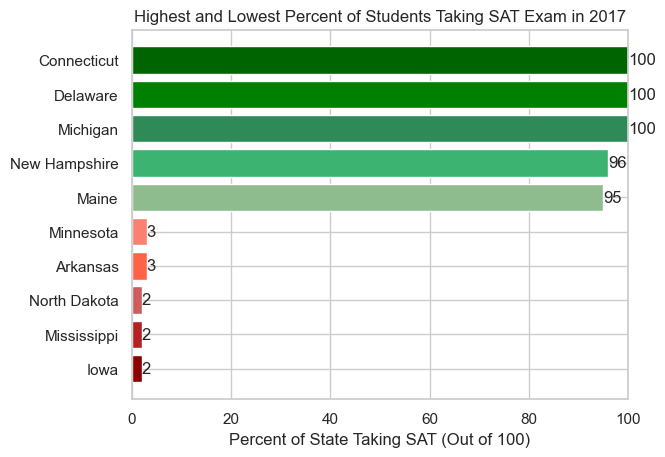

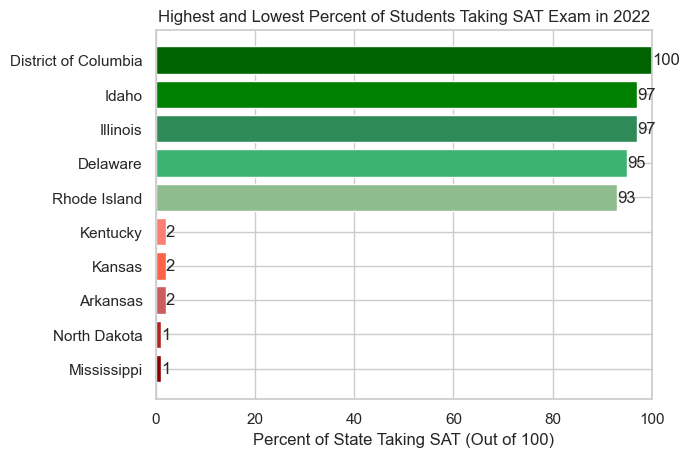

In [49]:
horizontal_bar_graph('Highest and Lowest Percent of Students Taking SAT Exam in 2017', 
                     clean_and_combine(int, 
                                       find_minmax('max', clean_data(2, 2, 4), clean_data(2, 2, 0), clean_data(2, 2, 4), 5), 
                                       2, 
                                       find_minmax('min', clean_data(2, 2, 4), clean_data(2, 2, 0), clean_data(2, 2, 4), 5), 
                                       2, 
                                       False, 
                                       True), 
                     'Percent of State Taking SAT (Out of 100)', 
                     100, 
                     clean_and_combine(str, 
                                       find_minmax('max', clean_data(2, 2, 4), clean_data(2, 2, 0), clean_data(2, 2, 4), 5), 
                                       0, 
                                       find_minmax('min', clean_data(2, 2, 4), clean_data(2, 2, 0), clean_data(2, 2, 4), 5), 
                                       0, 
                                       False, 
                                       True), 
                     barcolors)

horizontal_bar_graph('Highest and Lowest Percent of Students Taking SAT Exam in 2022', 
                     clean_and_combine(int, 
                                       find_minmax('max', clean_data(7, 2, 4), clean_data(7, 2, 0), clean_data(7, 2, 4), 5), 
                                       2, 
                                       find_minmax('min', clean_data(7, 2, 4), clean_data(7, 2, 0), clean_data(7, 2, 4), 5), 
                                       2, 
                                       False, 
                                       True), 
                     'Percent of State Taking SAT (Out of 100)', 
                     100, 
                     clean_and_combine(str, 
                                       find_minmax('max', clean_data(7, 2, 4), clean_data(7, 2, 0), clean_data(7, 2, 4), 5), 
                                       0, 
                                       find_minmax('min', clean_data(7, 2, 4), clean_data(7, 2, 0), clean_data(7, 2, 4), 5), 
                                       0, 
                                       False, 
                                       True), 
                     barcolors)

## Question 5: Cluster Analysis in 2022 Between Scores and Regions, Comparison of 2017 and 2022
***

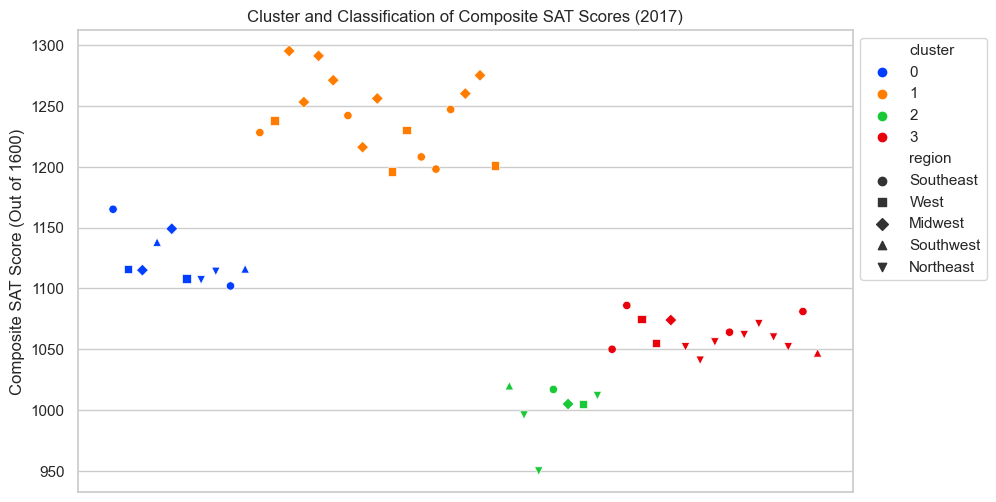

In [50]:
df_2017 = cluster(clean_2017, 'total_sat')
plot_cluster(df_2017, 
             'state', 
             'total_sat', 
             'Cluster and Classification of Composite SAT Scores (2017)', 
             'Composite SAT Score (Out of 1600)', 
             '')

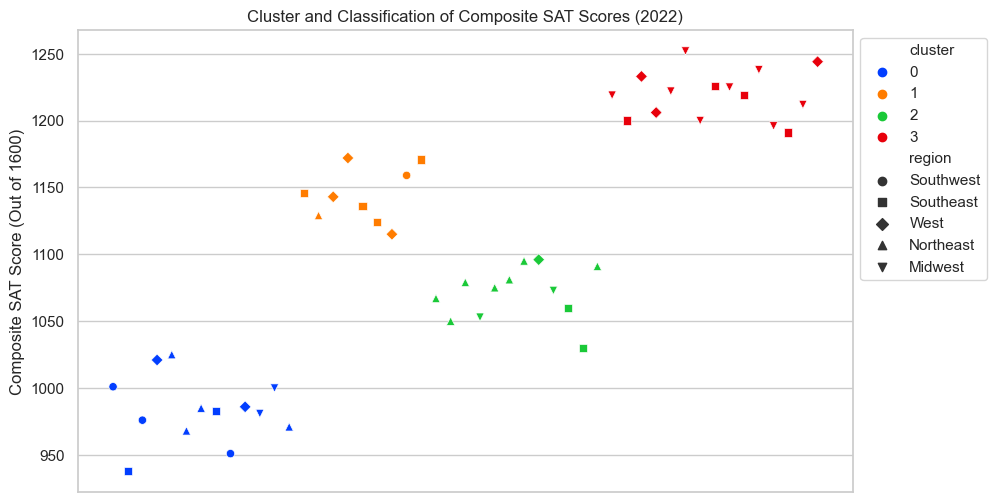

In [51]:
df_2022 = cluster(clean_2022, 'total_sat')
plot_cluster(df_2022, 
             'state', 
             'total_sat', 
             'Cluster and Classification of Composite SAT Scores (2022)', 
             'Composite SAT Score (Out of 1600)', 
             '')

## Question 6: Regression Analysis of Years and Scores (All Years)
***

                                   Year  Composite Score (Out of 1600)
Year                           1.000000                      -0.060495
Composite Score (Out of 1600) -0.060495                       1.000000


[Text(0.5, 1.0, 'Regression Analysis of Year and Total Scores')]

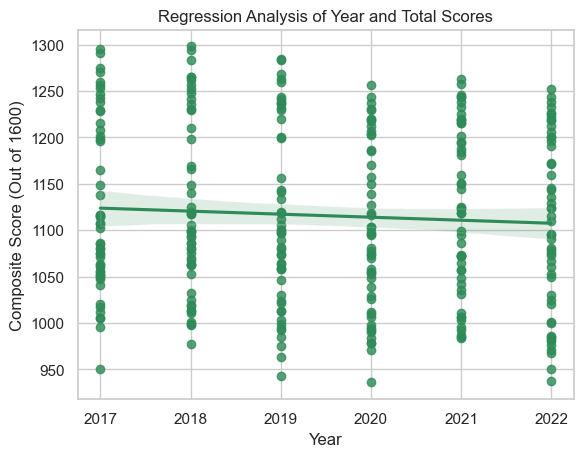

In [52]:
all_total_scoresdf = multifile_to_df(fileloc, 2, 1, int, 2017, 'Year', 'Composite Score (Out of 1600)')
rval_years = all_total_scoresdf.corr(method='pearson')
print(rval_years)
sns.regplot(data=all_total_scoresdf, 
            x='Year', 
            y='Composite Score (Out of 1600)', 
            color='seagreen').set(title='Regression Analysis of Year and Total Scores')

                                Year  Total Percent (Out of 100)
Year                        1.000000                   -0.076287
Total Percent (Out of 100) -0.076287                    1.000000


[Text(0.5, 1.0, 'Regression Analysis of Year and Percent Taking')]

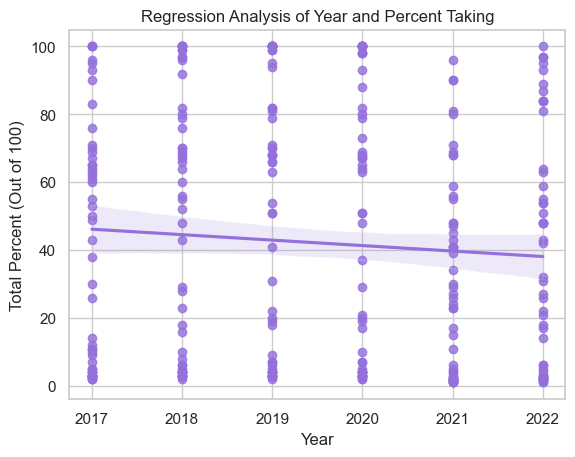

In [53]:
all_total_percentsdf = multifile_to_df(fileloc, 2, 4, int, 2017, 'Year', 'Total Percent (Out of 100)')
rval_percentsyears = all_total_percentsdf.corr(method='pearson')
print(rval_percentsyears)
sns.regplot(data=all_total_percentsdf, 
            x='Year', 
            y='Total Percent (Out of 100)', 
            color='mediumpurple').set(title='Regression Analysis of Year and Percent Taking')